# Extractive Summarization using LSTM-GAT

## imports

In [1]:
import json
import numpy as np
import networkx as nx

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader, random_split

import torch_geometric
import torch_geometric.transforms as T
from torch_geometric.nn import GATConv
from torch_geometric.utils import from_networkx, from_scipy_sparse_matrix
from torch_geometric.utils import to_networkx

from transformers import AlbertTokenizer, AlbertModel, AlbertConfig

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import pairwise_distances

# model load
from models import LSTM, GATClassifier, BasicSummarizer

In [2]:
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")

In [3]:
DEVICE

device(type='cuda')

## BasicSummarizer with GDC

In [261]:
import matplotlib.pyplot as plt

In [287]:
class BasicSummarizerWithGDC(nn.Module):
    
    def __init__(self, 
                 in_dim, 
                 hidden_dim, 
                 out_dim, 
                 num_heads, 
                 num_classes=2, 
                 g_transform=None):
        super(BasicSummarizerWithGDC, self).__init__()
        
        self.tokenizer = AlbertTokenizer.from_pretrained('albert-base-v2')
        self.tokenizer.padding_side = 'left'
        self.embedder = LSTM(self.tokenizer.vocab_size)
        self.gat_classifier = GATClassifier(in_dim, hidden_dim, out_dim, num_heads, num_classes)
        self.g_transform = g_transform
        
    def get_tokenize(self, docs):
        sent_tokens = [
            torch.cat(
                [self.tokenizer.encode(
                        sentences[i],
                        add_special_tokens=True,
                        max_length=128,
                        pad_to_max_length=True,
                        return_tensors='pt'
                 ) for i in range(len(sentences))]
            ) for sentences in docs
        ]

        sent_tokens = torch.cat([*sent_tokens])
        return sent_tokens
    
    def get_sentence_embedding(self, word_vecs, offsets):
        '''get node-featrues(setences embedding)'''
        features = []
        for idx in range(len(offsets) - 1):
            features.append(word_vecs[ offsets[idx]: offsets[idx]+offsets[idx+1] ])
        
        return features
    
    def build_graph(self, features_list, tdms):
        '''get edge_index for GATLayer'''
        edge_index_list, edge_attr_list = [], []
        for features, tdm in zip(features_list, tdms):
            features = features.cpu()
            cosine_matrix = 1 - pairwise_distances(tdm, metric="cosine")

            G = nx.from_numpy_matrix(cosine_matrix)
            
            # Graph to SparseMatrix
            G = nx.to_scipy_sparse_matrix(G)
            # sparse Matrix to Graph
            edge_index, edge_attr = from_scipy_sparse_matrix(G)
            
            edge_index_list.append(edge_index)
            edge_attr_list.append(edge_attr)

        return edge_index_list, edge_attr_list
    
    def gat_dataloader(self, features_list, edge_index_list, edge_attr_list, labels_list, batch_size):
        data_list = [
            torch_geometric.data.Data(x=features, edge_index=edge_index, edge_attr=edge_attr, y=labels)
                for features, edge_index, edge_attr, labels in zip(features_list, edge_index_list, edge_attr_list, labels_list)
        ]
        
#         self.before_data_list = data_list
#         bf_data_list = data_list
#         bf_data = bf_data_list[0]
#         bf_adj = to_scipy_sparse_matrix(bf_data.edge_index)
#         G = nx.from_scipy_sparse_matrix(bf_adj)
#         nx.draw(G, with_labels=True)
#         plt.savefig('./bf.png')
        
        
        gdc_data_list = [self.g_transform(data) for data in data_list]
        
#        self.after_data_list = gdc_data_list
        af_data_list = gdc_data_list
        af_data = af_data_list[0]
        af_adj = to_scipy_sparse_matrix(af_data.edge_index)
        G2 = nx.from_scipy_sparse_matrix(af_adj)
        nx.draw(G2, with_labels=True)
        plt.savefig('./af.png')
        
#         G_check = to_networkx(data_list[0], to_undirected=True)
#         nx.draw(G_check, with_labels=True)
        
        gat_loader = torch_geometric.data.DataLoader(gdc_data_list, batch_size=batch_size, shuffle=False)
        return gat_loader
    

    def forward(self, 
                docs, 
                offsets,
                tdms,
                labels_list, 
                threshold=0.2, 
                batch_size=32):
        
        sent_tokens = self.get_tokenize(docs).to(DEVICE)
        word_vecs = self.embedder(sent_tokens)
        features_list = self.get_sentence_embedding(word_vecs, offsets)
        edge_index_list, edge_attr_list = self.build_graph(features_list, tdms)
        
        # dataloader for GATLayer
        dataloader = self.gat_dataloader(features_list, edge_index_list, edge_attr_list, labels_list, batch_size)
        
        output = self.gat_classifier(next(iter(dataloader)))
        return output

## dataloader

### 1) Summary Dataset

In [179]:
def generate_batch(batch):
    docs = [entry[0] for entry in batch]
    labels = [entry[1] for entry in batch]
    tdms = [entry[2] for entry in batch]
    
    offsets = [0] + [len(doc) for doc in docs]
        
    return docs, offsets, labels, tdms

In [133]:
class SummaryDataset(Dataset):
    
    def __init__(self, path):
        
        with open(path, 'r', encoding='utf8') as f:
            self.data = [json.loads(line) for line in f]
        
    def __len__(self):
        """Returns the number of data."""
        return len(self.data)
    
    def __getitem__(self, idx):
        sentences = self.data[idx]['doc'].split('\n')
        labels = self.data[idx]['labels'].split('\n')
        labels = [int(label) for label in labels]
        
        tfidf = TfidfVectorizer().fit(sentences)
        tdm = tfidf.transform(sentences).toarray()
        
        return sentences, labels, tdm

### 2) dataset load (train, valid, test)

In [134]:
train_path = '../../data/summary/data/train.json'
valid_path = '../../data/summary/data/val.json'
test_path = '../../data/summary/data/test.json'

trainset = SummaryDataset(train_path)
validset = SummaryDataset(valid_path)
testset = SummaryDataset(test_path)

### 3) Dataloader for Summarizer

In [180]:
train_dataloader = DataLoader(trainset, 
                              batch_size=1, 
                              shuffle=False, 
                              collate_fn=generate_batch)

valid_dataloader = DataLoader(validset, 
                              batch_size=1, 
                              shuffle=False,
                              collate_fn=generate_batch)

test_dataloader = DataLoader(testset, 
                             batch_size=1, 
                             shuffle=False,
                             collate_fn=generate_batch)

### 4) GDC 

In [293]:
gdc = T.GDC(self_loop_weight=1, normalization_in='sym',
            normalization_out='col',
            diffusion_kwargs=dict(method='ppr', alpha=0.05),
            sparsification_kwargs=dict(method='topk', k=5,
                                           dim=0), exact=True)

### 5) Model Load

In [294]:
net = BasicSummarizerWithGDC(in_dim=128,
                             hidden_dim=64,
                             out_dim=32,
                             num_heads=2,
                             num_classes=1, 
                             g_transform=gdc).to(DEVICE)

In [295]:
batch = next(iter(train_dataloader))

In [296]:
docs, offsets, labels_list, tdms = batch

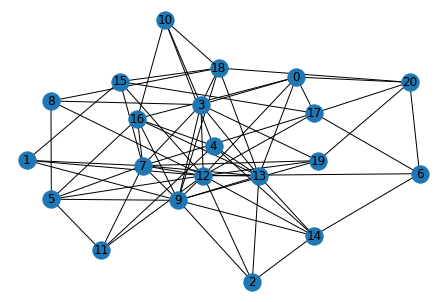

In [297]:
output = net(docs, offsets, tdms, labels_list)

In [298]:
output.size()

torch.Size([1, 21, 1])

In [299]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [300]:
labels_list = [torch.tensor(labels, dtype=torch.float) for labels in labels_list]

labels = torch.cat(labels_list)
labels = labels.view(-1, output.size()[1])
labels = labels.to(DEVICE)

In [301]:
optimizer.zero_grad()

output = output.view(-1, output.size()[1])
loss = criterion(output, labels)
loss.backward()
optimizer.step()

In [302]:
loss

tensor(0.6775, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)

In [241]:
from torch_geometric.utils import to_scipy_sparse_matrix  

In [242]:
bf_data_list = net.before_data_list
bf_data = bf_data_list[0]

bf_adj = to_scipy_sparse_matrix(bf_data.edge_index)

In [243]:
bf_data

Data(edge_attr=[63], edge_index=[2, 63], x=[21, 128], y=[21])

In [244]:
af_data_list = net.after_data_list
af_data = af_data_list[0]

af_adj = to_scipy_sparse_matrix(af_data.edge_index)

In [245]:
af_data

Data(edge_attr=[63], edge_index=[2, 63], x=[21, 128], y=[21])

In [246]:
G = nx.from_scipy_sparse_matrix(bf_adj)

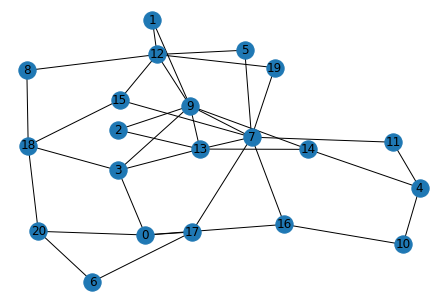

In [247]:
nx.draw(G, with_labels=True)

In [248]:
G.degree

DegreeView({0: 6, 1: 4, 2: 4, 3: 6, 4: 5, 5: 4, 6: 4, 7: 10, 8: 4, 9: 9, 10: 4, 11: 4, 12: 8, 13: 7, 14: 5, 15: 5, 16: 5, 17: 5, 18: 6, 19: 4, 20: 5})

In [249]:
G = nx.from_scipy_sparse_matrix(af_adj)

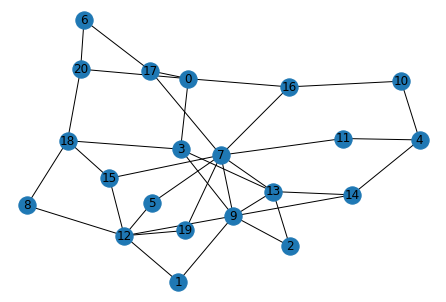

In [250]:
nx.draw(G, with_labels=True)

In [251]:
G.degree

DegreeView({0: 6, 1: 4, 2: 4, 3: 6, 4: 5, 5: 4, 6: 4, 7: 10, 8: 4, 9: 9, 10: 4, 11: 4, 12: 8, 13: 7, 14: 5, 15: 5, 16: 5, 17: 5, 18: 6, 19: 4, 20: 5})

In [201]:
# g_data = gdc(bf_data)

In [202]:
# g_adj = to_scipy_sparse_matrix(g_data.edge_index)

In [203]:
# G = nx.from_scipy_sparse_matrix(g_adj)
# nx.draw(G, with_labels=True)

In [253]:
cosine_matrix = 1 - pairwise_distances(tdms[0], metric="cosine")
G = nx.from_numpy_matrix(cosine_matrix)

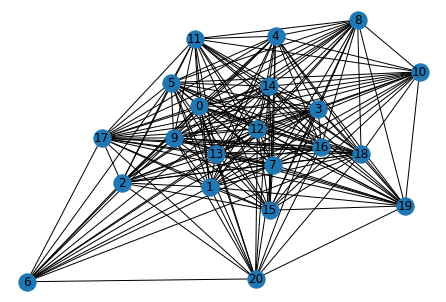

In [254]:
nx.draw(G, with_labels=True)